## Sentiment Analysis IMDB Movie Reviews
### DS 7337 - Natural Laguage Processing - Homework 8
#### George C. Sturrock
##### April 14, 2019
##### Homework 8 Objectives
Perform a vocabulary-based sentiment analysis of the movie reviews you used in homework 5 and homework 7, by doing the following:
1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.

2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

3.	For extra credit, analyze sentiment of chunks as follows:
        a.	Take the chunks from homework 5, and in Python, run each chunk individually through your sentiment analyzer that you used in question 1. If the chunk registers a nonneutral sentiment, save it in a tabular format (the chunk, the sentiment score).
        b.	Now sort the table twice, once to show the highest negative-sentiment-scoring chunks at the top and again to show the highest positive-sentiment-scoring chunks at the top. Examine the upper portions of both sorted lists, to identify any trends, and explain what you see. 

#### Import Libraries

In [1]:
import platform; print("Platform:", platform.platform())
import os
import sys; print("Python:", sys.version)
import requests; print("Requests:", requests.__version__)
from urllib import request; ("urllib:", request.__version__)
import warnings
warnings.filterwarnings('ignore')
from time import sleep

#Web Scraping
import bs4; print("BeatifulSoup:", bs4.__version__)
from bs4 import BeautifulSoup
import json; print("json:", json.__version__)

#Python Basics
import numpy as np; print("Numpy Version:", np.__version__)
import pandas as pd; print("Pandas Version:", pd.__version__)
from matplotlib import pyplot as plt
import seaborn as sns;

#scikit learn
from sklearn import metrics
from sklearn.feature_extraction import stop_words
#print(stop_words.ENGLISH_STOP_WORDS)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#HAC
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering
#KMeans
from sklearn.cluster import KMeans

import pattern; print("Pattern Version:", pattern.__version__)
from pattern.en import tag, parse
from pattern.en import parsetree
from pattern.en import sentiment, positive
from pattern.vector import Document, Model, TFIDF, TF

Platform: Windows-10-10.0.14393-SP0
Python: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Requests: 2.21.0
BeatifulSoup: 4.7.1
json: 2.0.9
Numpy Version: 1.15.4
Pandas Version: 0.23.0
Pattern Version: 3.6


### Data Acquisition
The first three films in the "Rocky" series will be utilized to collect reviews for noun phrase chunking.  Link to the main user review page for each of the three movies are shown below.  To assure both positive and negative reviews are collected, there are two links per movie.  One is sorted descending by user rating.  The other is sorted ascending by user rating.  Both links have "spoiler alert" messages suppressed as these reviews are often more akin to a summarization of the movie plot instead of a true review.  

In [2]:
#Rocky movie list.  Two links for each movie to assure positive and negative reviews are captured.  
#Sort descending by Review Rating.  Sort ascending by Review Rating.

#Rocky
rockyDict = {"aRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0", 
         "dRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0", 
#Rocky 2
         "dRocky 2":"https://www.imdb.com/title/tt0079817/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 2":"https://www.imdb.com/title/tt0079817/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0",
#Rocky 3
         "dRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0"
            }

rockyKeys = rockyDict.keys()

#### Web Scraping IMDB Movie Review Titles
The individual links to the user reviews are collected below.  A get request uses each of the links in the "rockyDict" python dictionary.  The response is parsed by Beautiful Soup to find the individual links to each individual review.  The review URLs along with the movie name are written to a dataframe named dfRockyReviews.

In [3]:
reviewUrls = list()
dfRockyReviews = pd.DataFrame(columns = ['Movie', 'ReviewURL'])

for r in rockyKeys:
    #print(r, rockyDict[r])
    response = requests.get(rockyDict[r])
    soup = BeautifulSoup(response.text, 'html.parser')
    rUrls = ["http:" + s.attrs['href'] for s in soup.find_all(href = True, class_ = 'title')]
    reviewUrls = reviewUrls + rUrls
    for u in rUrls:
        dfRockyReviews = dfRockyReviews.append({'Movie':r[1:], 'ReviewURL':u}, ignore_index=True)

A sample of the dfRockyReviews dataframe is shown below.

In [4]:
dfRockyReviews[0:5]

,Movie,ReviewURL
0,Rocky,http:/review/rw4247059/?ref_=tt_urv
1,Rocky,http:/review/rw0149538/?ref_=tt_urv
2,Rocky,http:/review/rw0149534/?ref_=tt_urv
3,Rocky,http:/review/rw3451942/?ref_=tt_urv
4,Rocky,http:/review/rw3647093/?ref_=tt_urv


#### Web Scraping IMDB Movie Review Details
The individual review URLs collected above will be requested and parsed to retrieve key qualitative and categorical data about each review along with the review text itself.  These details are stored in a new dataframe named dfReviewDetails.  The first five records are this dataframe are shown below.

In [5]:
dfReviewDetails = pd.DataFrame(columns=['Movie', 'ReviewUrl', 'ReviewDate', 'ReviewTitle', 'Review', 'Rating', 
                                        'Language'])
counter = 0

for r in reviewUrls:
    fullUrl = "https://www.imdb.com" + r[5:]
    response2 = requests.get(fullUrl)
    soup2 = BeautifulSoup(response2.text, 'html.parser')
    rjson = soup2.find('script', type = 'application/ld+json').text
    rjson = json.loads(rjson)
    
    try:
        rating = rjson['reviewRating']['ratingValue']
    except Exception as e:
        #print("No User Rating")
        rating = 5
        
    ### Add stemming logic to review body
    
    dfReviewDetails = dfReviewDetails.append({'Movie':dfRockyReviews.Movie[counter], 'ReviewUrl':r, 
                                              'ReviewDate':rjson['dateCreated'], 'ReviewTitle':rjson['name'], 
                                              'Review':rjson['reviewBody'], 'Rating':rating, 
                                              'Language':rjson['inLanguage']}, ignore_index=True)
    counter += 1

dfReviewDetails.head()

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language
0,Rocky,http:/review/rw4247059/?ref_=tt_urv,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English
1,Rocky,http:/review/rw0149538/?ref_=tt_urv,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English
2,Rocky,http:/review/rw0149534/?ref_=tt_urv,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English
3,Rocky,http:/review/rw3451942/?ref_=tt_urv,2016-04-15,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,3,English
4,Rocky,http:/review/rw3647093/?ref_=tt_urv,2017-02-24,Eh....it was alright.,I didn't particularly like this movie. Dimwitt...,3,English


The bar plot below shows movie review ratings for the reviews collected in the prior step. The original "Rocky" is widely considered the best of the "Rocky" series.  It won multiple Oscars and introduced "Steady-Cam" technology to the movie world.  However, the sample of user reviews collected tell a different story.  

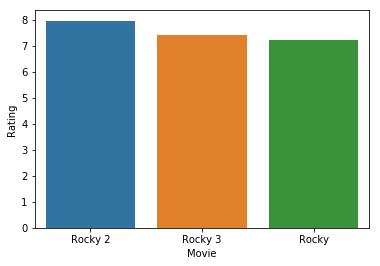

In [6]:
plotdf = dfReviewDetails.sort_values(by=['ReviewDate'])
plotdf.Rating = plotdf.Rating.astype('int64')
plotdf.ReviewDate = pd.to_datetime(plotdf.ReviewDate)
plotdf = plotdf.groupby(['Movie']).mean().reset_index()
sns.barplot(x='Movie', y='Rating', data=plotdf.sort_values(by=['Rating'], ascending=False))

### Review Clustering

# Add additional cleansing such as stemming prior to vectorization
For this requirement, the IMDB reviews will be clustered using K-Means and Hiearchical Agglomerative Clustering.  The results are presented in the sections below.  The first step is to produce a vectorized matrix the review text.

In [7]:
tfidfVectorizer = TfidfVectorizer(max_df=1, min_df=0, stop_words='english', use_idf=True, ngram_range=(1,3))

tfidfMatrix = tfidfVectorizer.fit_transform(dfReviewDetails.Review)
tfidfMatrix.shape

(150, 28668)

#### KMeans Clustering
The following code chunk determines the optimum combination of clusters, relative tolerance, and method of initialization based on the silhouette score.  The silhouette scores produced by the KMeans algorithm are all negative.  This indicates the clustering algorithm may not have effectively clustered the data.

In [8]:
bestSilScore = -9999999999999
rState = 20190325
tolList = [0.1, 0.01, 0.001, 0.0001]
initList = ['k-means++', 'random']

for i in range(2, 7, 1):
    for t in tolList:
        for n in initList:
            km = KMeans(n_clusters=i, tol=t, init=n, random_state=rState)
            kmFit = km.fit(tfidfMatrix)
            clusters = km.labels_.tolist()
            silScore = metrics.silhouette_score(tfidfMatrix, km.labels_)
            if silScore > bestSilScore:
                print("Clusters: ", i, "| tol:", t, "| Init", n, "| Silhouette Score:", silScore)
                bestSilScore = silScore
                nClust = i
                nTol = t
                nInit = n

Clusters:  2 | tol: 0.1 | Init k-means++ | Silhouette Score: 1.798279229345808e-15
Clusters:  2 | tol: 0.1 | Init random | Silhouette Score: 1.994017422528385e-15


The optimum combination of KMeans parameters are shown below.

In [9]:
print("Optimum Number of Clusters:", nClust)
print("Optimum tol:", nTol)
print("Optimum Init:", nInit)

Optimum Number of Clusters: 2
Optimum tol: 0.1
Optimum Init: random


The KMeans model is instantiated and fit to the vectorized matrix created from the movie reviews.

In [10]:
km = KMeans(n_clusters=nClust, tol=nTol, init=nInit, random_state=rState)
kmFit = km.fit(tfidfMatrix)
clusters = km.labels_.tolist()

Next, a dictionary with the cluster per observation is assembled.  The dictionary is then converted to a pandas dataframe for processing.

In [11]:
reviewDict = {'cluster': clusters, 'movie': dfReviewDetails.Movie, 'rating': dfReviewDetails.Rating, 'title': dfReviewDetails.ReviewTitle, 
              'review': dfReviewDetails.Review}

In [12]:
dfKmClust = pd.DataFrame.from_dict(reviewDict)
dfKmClust['rating'] = dfKmClust['rating'].astype('int64')
#dfKmClust.head()

To provide additional depth of cluster analysis, the sentiment and polarity score for each review is calculated and attached to the KMeans clustering dataframe.

In [13]:
reviews = dfKmClust['review']
sa = []
pol = []

for r in dfKmClust['review']:
    tmp = sentiment(r)
    sa.append(round(tmp[0], 4))
    pol.append(round(tmp[1], 4))

In [14]:
dfKmClust['sentiment'] = sa
dfKmClust['polarity'] = pol

In [15]:
dfKmClust.head()

,cluster,movie,rating,title,review,sentiment,polarity
0,0,Rocky,1,Rubbish,The fight scenes are pathetic and the acting i...,-0.5000,0.6667
1,0,Rocky,1,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,-0.0500,0.3815
2,0,Rocky,2,overrated piece of cheese,grubby late-night fare achieved way too much s...,0.0757,0.5011
3,0,Rocky,3,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,-0.1371,0.5229
4,0,Rocky,3,Eh....it was alright.,I didn't particularly like this movie. Dimwitt...,0.1122,0.5667


KMeans created two clusters based on input defined above.  To call these clusters is generous at best.  Out of 150 total observations, 149 of them are in cluster 0.  This is not a helpful result.  We will proceed to examining the results of hierarchical clustering.

0    149
1      1
Name: cluster, dtype: int64


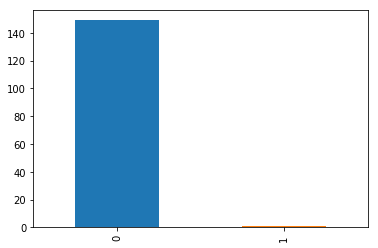

In [44]:
dfKmClust['cluster'].value_counts().plot(kind='bar')
print(dfKmClust['cluster'].value_counts())

In [25]:
#https://www.clips.uantwerpen.be/pages/pattern-vector#model

def clusterFeatures(list):
    docs = []
    for l in range(len(list)):
        docs.append(Document(list[l], type=list[l].strip('"')))
    mb = Model(documents=docs, weight=TFIDF)
    mfs = mb.feature_selection(top=12, threshold=0.2)
    return mb, mfs

#### Hierarchical Clustering
The optimum number of clusters for Hiearchical Agglomerative Clustering are determined and display.  The agglomerative clustering algorithm requires a dense matrix.  So, the vectorized matrix created for KMeans clustering is converted to a dense matrix.  The silhouette scores of the Hierachical Agglomerative Clustering algorithm are negative.  The algorithm may struggle with identifying meaningful clusters for this data set.

In [28]:
denseTfidf = tfidfMatrix.toarray()

In [29]:
bestSilScore = -999999999999
nClust2 = 0

for i in range(2, 15, 1):
    ac = AgglomerativeClustering(n_clusters=i, linkage='ward')
    acFit = ac.fit(denseTfidf)
    clusters2 = acFit.labels_.tolist()
    silScore = metrics.silhouette_score(denseTfidf, acFit.labels_)
    if silScore > bestSilScore:
        print("Clusters: ", i, "| Silhouette Score:", silScore)
        bestSilScore = silScore
        nClust2 = i

Clusters:  2 | Silhouette Score: -5.233641528945917e-18


In [30]:
print("Optimum Number of Clusters:", nClust2)

Optimum Number of Clusters: 2


The agglomerative clustering model is instantiated and fit using the dense vectorized matrix of terms.

In [31]:
ac = AgglomerativeClustering(n_clusters=nClust2, linkage='ward')
acFit = ac.fit(denseTfidf)
acFit.labels_
clusters2 = acFit.labels_.tolist()

In [32]:
dfacPlot = dfReviewDetails
dfacPlot['cluster'] = clusters2

The cluster for each document is appended to a dictionary containing the review-wise details.

In [33]:
reviewDict2 = {'cluster': clusters2, 'movie': dfReviewDetails.Movie, 'rating': dfReviewDetails.Rating, 'title': dfReviewDetails.ReviewTitle, 
              'review': dfReviewDetails.Review}

In [34]:
dfHacClust = pd.DataFrame.from_dict(reviewDict2)
dfHacClust['rating'] = dfHacClust['rating'].astype('int64')

To provide additional points of comparison, the sentiment and polarity scores for each review are attached to the dataframe.  The average sentiment and polarity will be calculated for these clusters as well to deteremine if this provides evidence of a different between clusters.

In [35]:
dfHacClust['sentiment'] = sa
dfHacClust['polarity'] = pol
dfHacClust.head()

,cluster,movie,rating,title,review,sentiment,polarity
0,0,Rocky,1,Rubbish,The fight scenes are pathetic and the acting i...,-0.5000,0.6667
1,0,Rocky,1,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,-0.0500,0.3815
2,1,Rocky,2,overrated piece of cheese,grubby late-night fare achieved way too much s...,0.0757,0.5011
3,0,Rocky,3,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,-0.1371,0.5229
4,1,Rocky,3,Eh....it was alright.,I didn't particularly like this movie. Dimwitt...,0.1122,0.5667


##### HAC Cluster Counts
Cluster 0 and 1 are the primary clusters identified by hierarchical agglomerative clustering.  This is a fairly balanced two-cluster result.  Additional analysis will continue to build intelligence behind potential cluster meaning.

0    82
1    68
Name: cluster, dtype: int64


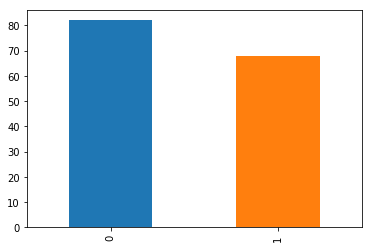

In [36]:
dfHacClust['cluster'].value_counts().plot(kind='bar')
print(dfHacClust['cluster'].value_counts())

##### Sentiment Analysis HAC
The mean sentiment analysis for each cluster is printed below.  The average sentiment analysis score for each cluster is shown below.  Cluster one is approximately .05 greater than cluster 0.  This suggests cluster 1 may contain more positive reviews.

In [37]:
clusterSent2 = dfHacClust['sentiment'].groupby(dfHacClust['cluster'])
print(clusterSent2.mean())

cluster
0    0.166012
1    0.213076
Name: sentiment, dtype: float64


##### Polarity Analysis HAC
There is very little difference in average polarity between cluster 0 and 1.  Cluster 1 is only .015 greater than cluster 0.

In [38]:
clusterPol2 = dfHacClust['polarity'].groupby(dfHacClust['cluster'])
print(clusterPol2.mean())

cluster
0    0.500191
1    0.515184
Name: polarity, dtype: float64


##### User Rating
The numerical IMDB user rating was captured during the web scraping review details.  The average IMDB user rating per cluster is shown below.  This offers a bit more proof of cluster 1 containing more positive reviews as the average review for cluster 1 is 0.47 greater than cluster 0.  It is important to note new reviews are added to this date for Rocky, Rocky 2, and Rocky 3.  Given the low silhouette scores produced by this algorithm, new reviews could tilt or totally disrupt the two cluster scheme produced by Hierarchical Agglomerative Clustering.  

In [50]:
clusterRate2 = dfHacClust['rating'].groupby(dfHacClust['cluster'])
print(clusterRate2.mean())

cluster
0    7.304878
1    7.779412
Name: rating, dtype: float64


##### HAC Movies per Cluster
Another observable difference in the content of the two clusters is the relative presence of Rocky 2 reviews.  Rocky 2 has the highest number of reviews on a per movie basis in cluster 0.  In cluster 1, Rocky 2 has the lowest number of reviews per movie.  

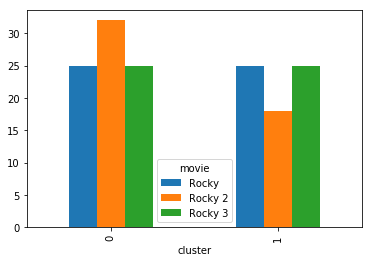

In [39]:
clusterMovie2 = dfHacClust.groupby(['movie', 'cluster']).size().sort_values(ascending=False).reset_index(name='count')
clusterMovie2.pivot(index='cluster', columns='movie', values='count').fillna(0).plot(kind='bar')

##### TFIDF Weighted Features per HAC Cluster
Cluster 0 is high on Rocky and low on Rocky 3 documents.  Cluster 1 is high on Rocky 3 and low on Rocky documents.  Again, there is no discernable difference in sentiment between the key features of the two primary clusters.  Cluster 1 does show Rocky 3 specific tokens of "iii" and "clubber".  Rocky's trainer "Mickey", played by Burgess Meredith also dies in Rocky 3.  The key features are very similar to those identified by KMeans clustering.  The same Pattern based method used for KMeans is called for the Hierarchical Agglomerative Clustering clusters.

In [40]:
dfHacClust0 = dfHacClust[dfHacClust.cluster == 0]
dfHacClust0.reset_index(inplace=True)
dfHacClust1 = dfHacClust[dfHacClust.cluster == 1]
dfHacClust1.reset_index(inplace=True)

In [41]:
mb1a, mfs1a = clusterFeatures(dfHacClust0['review'])
mb2a, mfs2a = clusterFeatures(dfHacClust1['review'])

In [42]:
print("Cluster 0")
print(mfs1a)
print()
print("Cluster 1")
print(mfs2a)

Cluster 0
['rocky', 'scenes', 'love', 'original', 'adrian', 'watch', 'series', 'character', 'sylvester', 'boxing', 'life', 'movies']

Cluster 1
['rocky', 'carl', 'characters', 'clubber', 'director', 'hard', 'makes', 'weathers', 'balboa', 'champion', 'world', 'character']


### Question 7.2
KMeans clustering did not produce suitable clusters for analysis with the parameters used to fit the model above.  The cluster analysis focuses on the two clusters produced by Hierarchical Agglomerative Clustering (HAC).  From the analysis above, HAC cluster 1 is slightly more positive and contains proportionally less Rocky 2 reviews compared to HAC cluster 0.  The top 12 TDIDF text features per cluster are more difficult to interpret.  The key features in both clusters are full of character and actor names.  Key terms such as 'champion' and 'world' could be indicative of positive reviews.  However, the token "love" is present cluster 0's key features.  Additional data cleansing could improve the key features lists.  The TF and TFIDF scores for the top 12 key features show there is little similarity structurally between the top features identified by Hierarchical Agglomerative Clustering.  This suggests HAC did a decent job at finding unique features despite the low sillouette scores.  In conclusion, it is difficult to determine the semantic center of each cluster.  Several reasons could be at play.  First, the plot and character recycling in Rocky, Rocky 2 and Rocky 3 could lead to reviews with features which are difficult to distinguish.  

In [43]:
d172 = Document(mfs1a)
d272 = Document(mfs2a)
mb72 = Model(documents=[d172, d272], weight=TF)
print("TF Cosine Similarity", round(mb72.similarity(d172, d272),4))
mb72 = Model(documents=[d172, d272], weight=TFIDF)
print("TFIDF Cosine Similarity", mb72.similarity(d172, d272))

TF Cosine Similarity 0.1667
TFIDF Cosine Similarity 0.0


### Question 7.3
The Hierarchical Agglomerative Clustering algorithm clearly outperformed KMeans for the data set collected on March 31, 2019.  This is a fairly straighforward assessment as the two cluster KMeans fit failed to produce two meaningful clusters.  Further testing of the KMeans algorithm showed that a five cluster KMeans fit would produce better results.  However, three outlier clusters of one observation were produced.  Conversely, Hierarchical Agglomerative Clustering identifed two fairly balanced clusters with some potentially meaningful differences in sentiment, user rating and movie composition.  However, the low silhouette scores suggest more clustering algorithms should be tested for this data set.  

### Code Appendix

In [61]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
#plt.figure(figsize=(50,50))
#children = acFit.children_
#distance = np.arange(children.shape[0])
#no_of_observations = np.arange(2, children.shape[0]+2)
#linkageMatrix = np.column_stack([children, distance, no_of_observations]).astype(float)
#
#dn = dendrogram(linkageMatrix, labels=dfReviewDetails.index, p=30, truncate_mode='level', orientation='right', show_leaf_counts=True, leaf_font_size = 9)
#dn = dendrogram(linkageMatrix, labels=dfReviewDetails.index, show_leaf_counts=False, orientation='right', leaf_font_size=10)
#
#plt.show()

In [60]:
#viz = InterclusterDistance(km)
#viz.fit(tfidfMatrix)
#viz.poof()